In [1]:
import torch
import os
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from training_data import CombinedData
from PIL import Image
from matplotlib import pyplot as plt

data_train = CombinedData('HASY')
data_test = CombinedData('HASY', train=False)

print("Train data length: {0}".format(len(data_train.data)))
print("Test data length: {0}".format(len(data_test.data)))
print("Img Shape: {0}".format(data_train.data[0].shape))
print("Number of Labels: {0}".format(data_train.no_labels))

  0%|          | 0/10000 [00:00<?, ?it/s]

No training data for 0. Skipping
No training data for 1. Skipping
No training data for 2. Skipping
No training data for 3. Skipping
No training data for 4. Skipping
No training data for 5. Skipping
No training data for 6. Skipping
No training data for 7. Skipping
No training data for 8. Skipping
No training data for 9. Skipping
No training data for +. Skipping


100%|██████████| 10000/10000 [00:00<00:00, 339553.77it/s]

No training data for 0. Skipping
No training data for 1. Skipping
No training data for 2. Skipping
No training data for 3. Skipping
No training data for 4. Skipping
No training data for 5. Skipping
No training data for 6. Skipping
No training data for 7. Skipping
No training data for 8. Skipping
No training data for 9. Skipping
No training data for +. Skipping
Train data length: 60405
Test data length: 10045
Img Shape: torch.Size([1, 32, 32])
Number of Labels: 11


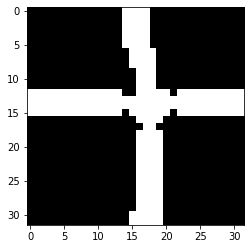

Label: 10


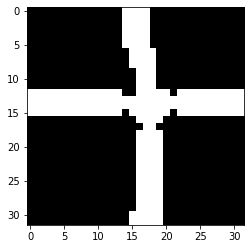

Label: 10


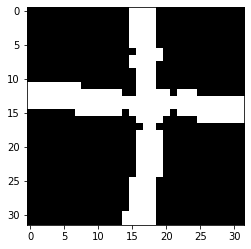

Label: 10


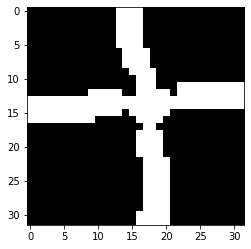

Label: 10


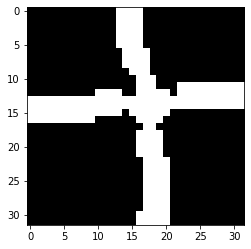

Label: 10


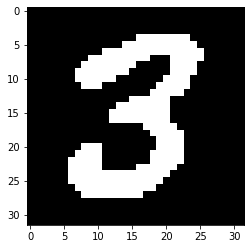

Label: 3


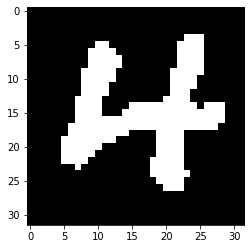

Label: 4


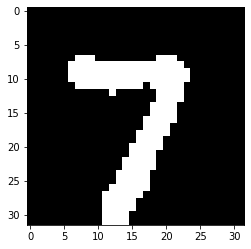

Label: 7


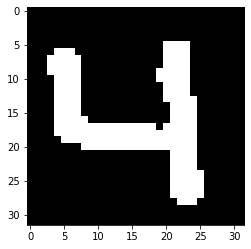

Label: 4


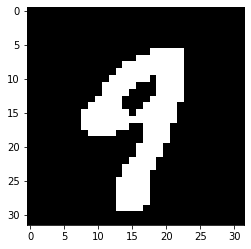

Label: 9


In [2]:
from torchvision import transforms
for i in range(5):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_train.targets[i])
for i in range(7000, 7005):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_train.targets[i])

In [9]:
# Train with a pretrained model from PyTorch
from torchvision import models
from torch.nn import Conv2d

pretrained = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch_model = models.alexnet(num_classes=15)
torch_model.features[0] = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
if pretrained:
    torch_model.load_state_dict(torch.load('pretrained-model-01.ckpt'))
torch_model.to(device)
epochs = 5
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001, betas=(0.95, 0.95), weight_decay=0)
criterion = nn.CrossEntropyLoss()

def calc_accuracy(model):
    accuracies = []
    for idx, [x_test, y_test] in enumerate(tqdm(test_loader)):
        test_pred = model(x_test.to(device))
        accuracy = 100 * torch.mean((torch.argmax(test_pred.to(device), dim=1) == y_test.to(device)).float())
        accuracies.append(accuracy.item())
    return np.mean(accuracies)  

train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
test_loader = DataLoader(data_test, batch_size=16, shuffle=False)

print(torch_model)
print(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3):

In [11]:
for epoch in range(epochs):
    print("Epoch {0}".format(epoch))
    acc = calc_accuracy(torch_model)
    print("Accuracy: {0}".format(acc))
    if acc > 80:
        torch.save(torch_model.state_dict(), 'combined-model-{0}.ckpt'.format(acc))
    for step, [x_train, y_train] in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        train_pred = torch_model(x_train.to(device))
        loss = criterion(train_pred, y_train.to(device))
        loss.backward()
        optimizer.step()
        if step % 500 == 0:
            print('Loss: {}'.format(loss))
acc = calc_accuracy(torch_model)
print("Accuracy: {0}".format(acc))
torch.save(torch_model.state_dict(), 'combined-model-v3.ckpt')

  5%|▍         | 29/628 [00:00<00:02, 289.78it/s]

Epoch 0


  0%|          | 5/3776 [00:00<01:36, 39.24it/s]

Accuracy: 40.23073861553411
Loss: 1.682278037071228


 13%|█▎        | 506/3776 [00:14<01:30, 35.96it/s]

Loss: 0.34208178520202637


 27%|██▋       | 1006/3776 [00:28<01:17, 35.78it/s]

Loss: 0.19000710546970367


 40%|███▉      | 1506/3776 [00:42<01:03, 36.03it/s]

Loss: 0.8395414352416992


 53%|█████▎    | 2006/3776 [00:55<00:50, 35.28it/s]

Loss: 0.10342337191104889


 66%|██████▋   | 2506/3776 [01:10<00:35, 35.51it/s]

Loss: 0.14119510352611542


 80%|███████▉  | 3006/3776 [01:24<00:21, 35.42it/s]

Loss: 0.37732744216918945


 93%|█████████▎| 3506/3776 [01:39<00:08, 30.84it/s]

Loss: 0.2921428978443146


  4%|▍         | 28/628 [00:00<00:02, 278.30it/s]

Epoch 1


100%|██████████| 628/628 [00:01<00:00, 333.54it/s]


Accuracy: 93.77985668789809


  0%|          | 8/3776 [00:00<01:41, 37.29it/s]

Loss: 0.0028061270713806152


 13%|█▎        | 508/3776 [00:14<01:40, 32.46it/s]

Loss: 0.028319641947746277


 27%|██▋       | 1008/3776 [00:29<01:18, 35.47it/s]

Loss: 1.2293858528137207


 40%|███▉      | 1508/3776 [00:43<01:03, 35.92it/s]

Loss: 0.020532473921775818


 53%|█████▎    | 2008/3776 [00:57<00:49, 35.43it/s]

Loss: 0.29435068368911743


 66%|██████▋   | 2508/3776 [01:11<00:35, 35.59it/s]

Loss: 0.1637805551290512


 80%|███████▉  | 3008/3776 [01:25<00:22, 33.72it/s]

Loss: 0.10318738222122192


 93%|█████████▎| 3508/3776 [01:40<00:07, 35.86it/s]

Loss: 0.01356351375579834


  5%|▍         | 29/628 [00:00<00:02, 281.25it/s]

Epoch 2


  0%|          | 0/3776 [00:00<?, ?it/s]

Accuracy: 95.74044585987261
Loss: 0.00022941827774047852


 13%|█▎        | 508/3776 [00:14<01:31, 35.58it/s]

Loss: 0.2701836824417114


 27%|██▋       | 1008/3776 [00:28<01:17, 35.66it/s]

Loss: 0.9524416327476501


 40%|███▉      | 1508/3776 [00:42<01:02, 36.02it/s]

Loss: 0.11515435576438904


 53%|█████▎    | 2008/3776 [00:56<00:49, 35.93it/s]

Loss: 0.14074045419692993


 66%|██████▋   | 2508/3776 [01:10<00:35, 35.37it/s]

Loss: 0.24019978940486908


 80%|███████▉  | 3008/3776 [01:25<00:21, 35.52it/s]

Loss: 0.5376364588737488


 93%|█████████▎| 3508/3776 [01:39<00:07, 35.57it/s]

Loss: 0.01664295792579651


  5%|▍         | 29/628 [00:00<00:02, 282.05it/s]

Epoch 3


  0%|          | 5/3776 [00:00<01:34, 39.97it/s]

Accuracy: 93.1031050955414
Loss: 0.001179516315460205


 13%|█▎        | 506/3776 [00:14<01:30, 36.23it/s]

Loss: 0.4042310416698456


 27%|██▋       | 1006/3776 [00:28<01:17, 35.88it/s]

Loss: 0.030833721160888672


 40%|███▉      | 1506/3776 [00:41<01:03, 35.98it/s]

Loss: 0.40007245540618896


 53%|█████▎    | 2006/3776 [00:56<00:49, 35.48it/s]

Loss: 0.9693219065666199


 34%|███▍      | 1301/3776 [15:29<1:05:25,  1.59s/it]

Loss: 0.17341390252113342


 37%|███▋      | 1401/3776 [19:37<1:54:19,  2.89s/it]

Loss: 0.0030768970027565956


 40%|███▉      | 1501/3776 [24:32<1:27:11,  2.30s/it]

Loss: 0.11671818047761917


 42%|████▏     | 1601/3776 [28:34<1:25:52,  2.37s/it]

Loss: 0.6137700080871582


  0%|          | 0/3776 [00:00<?, ?it/s]

Accuracy: 92.89410828025478
Loss: 0.036795079708099365


 13%|█▎        | 506/3776 [00:14<01:32, 35.46it/s]

Loss: 0.0034210681915283203


 27%|██▋       | 1006/3776 [00:29<01:18, 35.48it/s]

Loss: 0.1194816529750824


 40%|███▉      | 1506/3776 [00:43<01:03, 35.62it/s]

Loss: 0.16582675278186798


 53%|█████▎    | 2006/3776 [00:57<00:54, 32.64it/s]

Loss: 0.23630160093307495


 66%|██████▋   | 2506/3776 [01:12<00:35, 35.59it/s]

Loss: 0.45546114444732666


 80%|███████▉  | 3006/3776 [01:26<00:21, 35.51it/s]

Loss: 0.6352046132087708


 93%|█████████▎| 3506/3776 [01:40<00:08, 32.61it/s]

Loss: 0.07023423910140991


100%|██████████| 628/628 [00:01<00:00, 331.19it/s]

Accuracy: 95.00398089171975


In [ ]:
acc = calc_accuracy(torch_model)
print("Accuracy: {0}".format(acc))
torch.save(torch_model.state_dict(), 'combined-model-v3.ckpt')